# RNN Classification

Time to throw some deep learning at this problem.

In [27]:
%config Completer.use_jedi = False

In [314]:
# import libraries
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, SimpleRNN, InputLayer, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from kerastuner.tuners import RandomSearch

from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

sns.set()

/home/skelletor/.pyenv/versions/anaconda3-2020.02/envs/marketing-analysis/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [215]:
# load in our data
df = pd.read_csv("../data/processed/modeling-data.csv", index_col=0, parse_dates=True).iloc[:, [0, 1, 2, 3, -1]]
df.head()

,customer_id,recency,frequency,monetary,predictions
invoice_date,,,,,
2009-12-31,12346.0,1.000000,0.000972,0.003109,0
2010-01-31,12346.0,1.000000,0.000300,0.000511,0
2010-02-28,12346.0,0.666667,0.000000,0.000000,0
2010-03-31,12346.0,1.000000,0.000078,0.002470,0
2010-04-30,12346.0,0.800000,0.000000,0.000000,0


In [259]:
df.predictions.value_counts()

0    140025
5      7974
3       429
2        61
1        55
4         6
Name: predictions, dtype: int64

We want to transform our data into the following shape (samples, 5, 3), where 5 sequential months for our customer and 3 is the RFM values for that individual months. Our samples will be for each customer. 

In [173]:
# reshape our data into a 3d array
df_shaped = pd.pivot_table(df, index="customer_id", columns="invoice_date")

# put into 3d array of shape (customers, 24*months, 3*features + 1*target)
data = np.zeros((5942, 24, 4))

data[..., 0] = df_shaped["recency"].iloc[:, :-1].values
data[..., 1] = df_shaped["frequency"].iloc[:, :-1].values
data[..., 2] = df_shaped["monetary"].iloc[:, :-1].values
data[..., 3] = df_shaped["predictions"].shift(-1, axis=1).iloc[:, :-1].values

# reshape into (customers * (24-5)months, 5 months, 3 targets) and (samples, target*1)
X = np.zeros((19*5942, 5, 3))
y = np.zeros((19*5942, 1))
for i, customer in enumerate(data):
    for j in range(5, 24):
        values = customer[j-5:j]
        X[i] = values[:, :3]
        y[i] = values[-1, 3]

# set aside the last 3 months
idx = np.arange(1, X.shape[0]+1)
holdout_mask = (np.mod(idx, 19) == 17) | (np.mod(idx, 19) == 18) | (np.mod(idx, 19) == 0) 
val_mask = (np.mod(idx, 19) == 15) | (np.mod(idx, 19) == 16)


X_val, y_val, X_hold, y_hold = X[val_mask], y[val_mask], X[holdout_mask], y[holdout_mask]
standard = ~(val_mask | holdout_mask)
X_train, y_train = X[standard], y[standard]

## Baseline Neural Net

In [184]:
df.predictions.nunique()

6

In [199]:
# create a standard neural network
base = Sequential()

base.add(InputLayer(input_shape=X_train.shape[1:]))
base.add(SimpleRNN(32, return_sequences=True))
base.add(SimpleRNN(32))
base.add(Dense(32, activation="relu"))
base.add(Dense(6, activation="softmax"))

base.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [212]:
history = base.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_val, y_val))

Train on 83188 samples, validate on 11884 samples
Epoch 1/3
83188/83188 [==============================] - 4s 48us/sample - loss: 0.0042 - acc: 0.9985 - val_loss: 0.0048 - val_acc: 0.9981
Epoch 2/3
83188/83188 [==============================] - 4s 48us/sample - loss: 0.0044 - acc: 0.9983 - val_loss: 0.0031 - val_acc: 0.9987
Epoch 3/3
83188/83188 [==============================] - 4s 44us/sample - loss: 0.0043 - acc: 0.9985 - val_loss: 0.0037 - val_acc: 0.9984


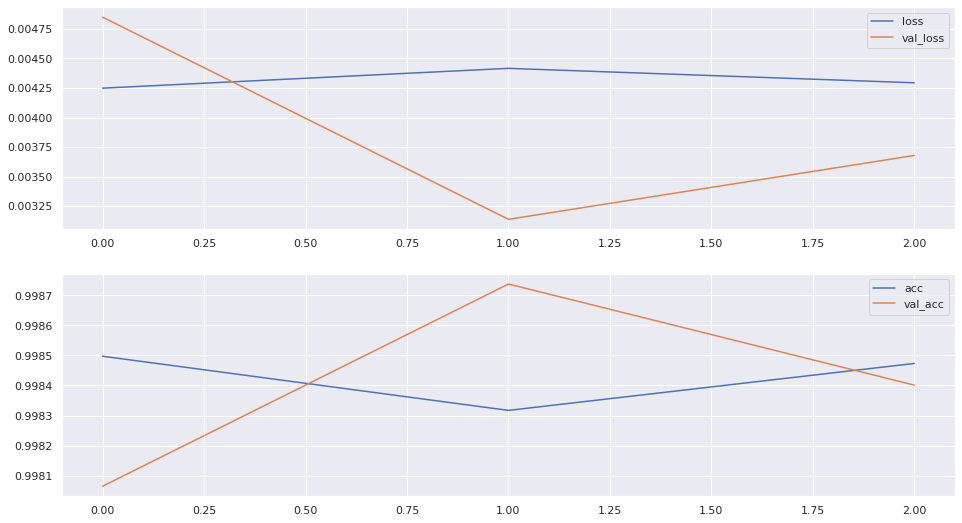

In [213]:
plt.figure(figsize=(16, 9))

plt.subplot(211)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(212)
plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")

plt.legend()
plt.show()

### LSTM

In [219]:
# create a standard neural network
lstm_mod = Sequential()

lstm_mod.add(Input(shape=X_train.shape[1:]))
lstm_mod.add(LSTM(32, return_sequences=True))
lstm_mod.add(Dropout(.4))
lstm_mod.add(LSTM(32))
lstm_mod.add(Dropout(.4))
lstm_mod.add(Dense(32, activation="relu"))
lstm_mod.add(Dropout(.4))
lstm_mod.add(Dense(6, activation="softmax"))

lstm_mod.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [307]:
weights = compute_class_weight(class_weight="balanced", classes=df.predictions.unique().astype(float), y=df.predictions)
weights_d = dict(enumerate(weights))

In [308]:
history = lstm_mod.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val), class_weight=weights_d)

Train on 83188 samples, validate on 11884 samples
Epoch 1/10
83188/83188 [==============================] - 11s 137us/sample - loss: 0.9964 - acc: 0.6103 - val_loss: 0.3574 - val_acc: 0.9562
Epoch 2/10
83188/83188 [==============================] - 10s 117us/sample - loss: 0.4564 - acc: 0.9020 - val_loss: 1.2333 - val_acc: 0.0041
Epoch 3/10
83188/83188 [==============================] - 10s 118us/sample - loss: 0.4593 - acc: 0.6250 - val_loss: 0.3407 - val_acc: 0.9562
Epoch 4/10
83188/83188 [==============================] - 11s 132us/sample - loss: 0.4924 - acc: 0.5745 - val_loss: 0.8099 - val_acc: 0.9530
Epoch 5/10
83188/83188 [==============================] - 11s 135us/sample - loss: 0.5448 - acc: 0.6756 - val_loss: 0.4126 - val_acc: 0.9546
Epoch 6/10
83188/83188 [==============================] - 10s 116us/sample - loss: 0.4067 - acc: 0.7926 - val_loss: 0.3570 - val_acc: 0.9562
Epoch 7/10
83188/83188 [==============================] - 10s 120us/sample - loss: 0.7329 - acc: 0.6385 

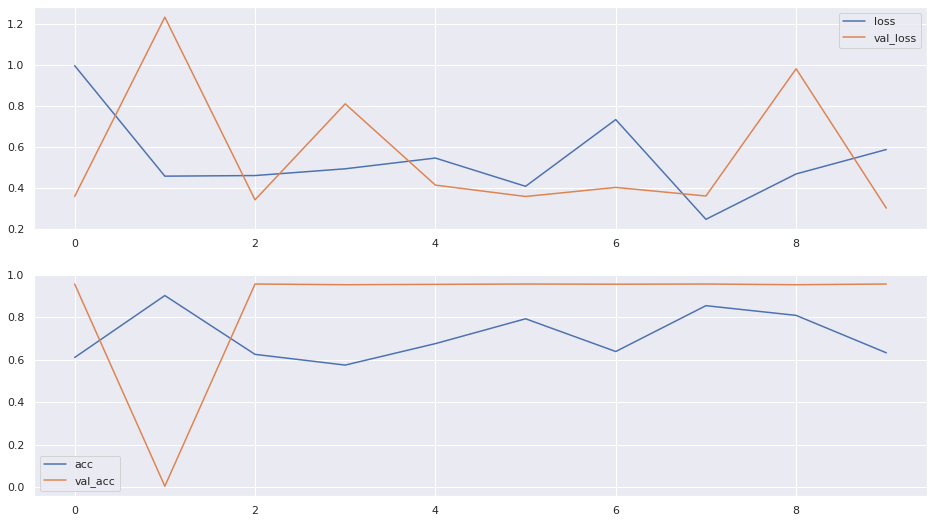

In [311]:
plt.figure(figsize=(16, 9))

plt.subplot(211)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(212)
plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")

plt.legend()
plt.show()

In [312]:
# accuracy on holdout data
preds = lstm_mod.predict_classes(X_hold)
s_weights = compute_sample_weight("balanced", y_hold)

print(accuracy_score(y_hold, preds, sample_weight=s_weights))

0.48106591865357673


Our accuracy on the holdout is severely low compared to the training and validation data.

## Tuning

In [315]:
# create a standard neural network
def build_model(hp):
    lstm_mod = Sequential()

    lstm_mod.add(Input(shape=X_train.shape[1:]))
    lstm_mod.add(LSTM(units=hp.Int("units",
                                  min_value=32,
                                  max_value=512,
                                  step=32), return_sequences=True))
    lstm_mod.add(Dropout(.4))
    lstm_mod.add(LSTM(hp.Int("units",
                                  min_value=32,
                                  max_value=512,
                                  step=32)))
    lstm_mod.add(Dropout(.4))
    lstm_mod.add(Dense(hp.Int("units",
                                  min_value=32,
                                  max_value=512,
                                  step=32), activation="relu"))
    lstm_mod.add(Dropout(.4))
    lstm_mod.add(Dense(6, activation="softmax"))

    lstm_mod.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                    optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))
    return lstm_mod

In [328]:
tuner = tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=1,
    executions_per_trial=1,
    directory='dir',
    project_name='marketing')

INFO:tensorflow:Reloading Oracle from existing project dir/marketing/oracle.json


In [329]:
call = [TensorBoard()]

In [333]:
history = tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=weights_d, batch_size=128, callbacks=call)

Train on 83188 samples, validate on 11884 samples
Epoch 1/10


25728/83188 [========>.....................] - ETA: 11:13 - loss: 116.6476 - acc: 0.92 - ETA: 6:10 - loss: 85.1708 - acc: 0.4727 - ETA: 4:26 - loss: 56.8739 - acc: 0.31 - ETA: 3:34 - loss: 42.8780 - acc: 0.33 - ETA: 3:03 - loss: 34.3987 - acc: 0.30 - ETA: 2:43 - loss: 28.7504 - acc: 0.30 - ETA: 2:27 - loss: 24.6612 - acc: 0.37 - ETA: 2:17 - loss: 21.5797 - acc: 0.45 - ETA: 2:08 - loss: 301.0346 - acc: 0.509 - ETA: 2:01 - loss: 374.4830 - acc: 0.556 - ETA: 1:55 - loss: 340.5748 - acc: 0.539 - ETA: 1:51 - loss: 312.4249 - acc: 0.495 - ETA: 1:47 - loss: 288.6902 - acc: 0.457 - ETA: 1:44 - loss: 268.4028 - acc: 0.426 - ETA: 1:40 - loss: 250.8628 - acc: 0.397 - ETA: 1:37 - loss: 235.5574 - acc: 0.373 - ETA: 1:35 - loss: 222.0452 - acc: 0.351 - ETA: 1:33 - loss: 210.0243 - acc: 0.331 - ETA: 1:31 - loss: 199.2464 - acc: 0.314 - ETA: 1:30 - loss: 189.5466 - acc: 0.298 - ETA: 1:28 - loss: 180.7339 - acc: 0.284 - ETA: 1:26 - loss: 172.6966 - acc: 0.271 - ETA: 1:25 - loss: 165.3402 - acc: 0.259 -

51840/83188 [=================>............] - ETA: 45s - loss: 134.5888 - acc: 0.30 - ETA: 45s - loss: 134.1200 - acc: 0.30 - ETA: 45s - loss: 133.6599 - acc: 0.30 - ETA: 45s - loss: 133.2058 - acc: 0.30 - ETA: 45s - loss: 132.7505 - acc: 0.30 - ETA: 44s - loss: 132.3044 - acc: 0.30 - ETA: 44s - loss: 131.8535 - acc: 0.30 - ETA: 44s - loss: 131.4046 - acc: 0.29 - ETA: 44s - loss: 130.9640 - acc: 0.29 - ETA: 44s - loss: 130.5333 - acc: 0.29 - ETA: 44s - loss: 130.0985 - acc: 0.29 - ETA: 44s - loss: 129.6650 - acc: 0.29 - ETA: 43s - loss: 129.2439 - acc: 0.29 - ETA: 43s - loss: 128.8179 - acc: 0.29 - ETA: 43s - loss: 128.7276 - acc: 0.28 - ETA: 43s - loss: 128.3005 - acc: 0.28 - ETA: 43s - loss: 127.8801 - acc: 0.28 - ETA: 43s - loss: 127.4617 - acc: 0.28 - ETA: 43s - loss: 127.0455 - acc: 0.28 - ETA: 43s - loss: 126.6301 - acc: 0.28 - ETA: 43s - loss: 126.2145 - acc: 0.28 - ETA: 43s - loss: 125.8014 - acc: 0.28 - ETA: 43s - loss: 125.3941 - acc: 0.27 - ETA: 43s - loss: 124.9850 - acc: 

77952/83188 [===========================>..] - ETA: 24s - loss: 106.9486 - acc: 0.19 - ETA: 24s - loss: 106.7451 - acc: 0.19 - ETA: 24s - loss: 106.5393 - acc: 0.19 - ETA: 23s - loss: 106.3363 - acc: 0.19 - ETA: 23s - loss: 106.1279 - acc: 0.19 - ETA: 23s - loss: 105.9202 - acc: 0.19 - ETA: 23s - loss: 105.7149 - acc: 0.19 - ETA: 23s - loss: 105.5126 - acc: 0.19 - ETA: 23s - loss: 105.3084 - acc: 0.19 - ETA: 23s - loss: 105.1072 - acc: 0.19 - ETA: 23s - loss: 104.9058 - acc: 0.19 - ETA: 23s - loss: 104.7008 - acc: 0.18 - ETA: 22s - loss: 104.5000 - acc: 0.18 - ETA: 22s - loss: 104.2978 - acc: 0.18 - ETA: 22s - loss: 104.0909 - acc: 0.18 - ETA: 22s - loss: 103.8884 - acc: 0.18 - ETA: 22s - loss: 103.6813 - acc: 0.18 - ETA: 22s - loss: 103.6244 - acc: 0.18 - ETA: 22s - loss: 103.4220 - acc: 0.18 - ETA: 22s - loss: 103.2131 - acc: 0.18 - ETA: 22s - loss: 103.3985 - acc: 0.18 - ETA: 22s - loss: 103.3731 - acc: 0.18 - ETA: 21s - loss: 103.1722 - acc: 0.18 - ETA: 21s - loss: 102.9806 - acc: 

83188/83188 [==============================] - ETA: 3s - loss: 122.0648 - acc: 0.171 - ETA: 3s - loss: 121.9240 - acc: 0.171 - ETA: 3s - loss: 121.7904 - acc: 0.170 - ETA: 3s - loss: 121.6599 - acc: 0.170 - ETA: 3s - loss: 121.5357 - acc: 0.170 - ETA: 3s - loss: 121.4146 - acc: 0.170 - ETA: 3s - loss: 121.2955 - acc: 0.169 - ETA: 3s - loss: 121.1856 - acc: 0.169 - ETA: 2s - loss: 121.0766 - acc: 0.169 - ETA: 2s - loss: 121.1373 - acc: 0.169 - ETA: 2s - loss: 121.0379 - acc: 0.168 - ETA: 2s - loss: 120.9371 - acc: 0.168 - ETA: 2s - loss: 120.8370 - acc: 0.168 - ETA: 2s - loss: 120.7454 - acc: 0.168 - ETA: 2s - loss: 120.6462 - acc: 0.167 - ETA: 2s - loss: 120.5511 - acc: 0.167 - ETA: 2s - loss: 120.4570 - acc: 0.167 - ETA: 2s - loss: 120.3627 - acc: 0.167 - ETA: 2s - loss: 120.2805 - acc: 0.166 - ETA: 1s - loss: 120.1903 - acc: 0.166 - ETA: 1s - loss: 120.1022 - acc: 0.166 - ETA: 1s - loss: 120.0071 - acc: 0.166 - ETA: 1s - loss: 119.9188 - acc: 0.165 - ETA: 1s - loss: 119.8236 - acc: 0

26112/83188 [========>.....................] - ETA: 40s - loss: 53.7602 - acc: 0.015 - ETA: 41s - loss: 51.8673 - acc: 0.011 - ETA: 42s - loss: 50.5735 - acc: 0.020 - ETA: 43s - loss: 48.9258 - acc: 0.029 - ETA: 43s - loss: 48.2633 - acc: 0.031 - ETA: 43s - loss: 47.0086 - acc: 0.033 - ETA: 43s - loss: 46.3993 - acc: 0.037 - ETA: 43s - loss: 45.4747 - acc: 0.043 - ETA: 43s - loss: 45.0037 - acc: 0.046 - ETA: 43s - loss: 44.1946 - acc: 0.048 - ETA: 43s - loss: 43.9534 - acc: 0.050 - ETA: 43s - loss: 43.2379 - acc: 0.054 - ETA: 43s - loss: 42.6271 - acc: 0.060 - ETA: 43s - loss: 41.7786 - acc: 0.069 - ETA: 43s - loss: 41.1373 - acc: 0.072 - ETA: 43s - loss: 40.5885 - acc: 0.078 - ETA: 43s - loss: 39.9897 - acc: 0.084 - ETA: 43s - loss: 39.2586 - acc: 0.092 - ETA: 43s - loss: 38.5293 - acc: 0.103 - ETA: 42s - loss: 37.9053 - acc: 0.112 - ETA: 42s - loss: 37.3566 - acc: 0.123 - ETA: 42s - loss: 36.6580 - acc: 0.137 - ETA: 42s - loss: 36.2963 - acc: 0.144 - ETA: 42s - loss: 35.7440 - acc: 0

52224/83188 [=================>............] - ETA: 30s - loss: 158.3362 - acc: 0.06 - ETA: 30s - loss: 157.9723 - acc: 0.06 - ETA: 30s - loss: 157.5829 - acc: 0.06 - ETA: 30s - loss: 157.1891 - acc: 0.06 - ETA: 30s - loss: 157.3011 - acc: 0.06 - ETA: 30s - loss: 156.9628 - acc: 0.06 - ETA: 30s - loss: 156.5724 - acc: 0.06 - ETA: 30s - loss: 156.2099 - acc: 0.06 - ETA: 29s - loss: 155.8484 - acc: 0.06 - ETA: 29s - loss: 163.4648 - acc: 0.06 - ETA: 29s - loss: 163.0815 - acc: 0.06 - ETA: 29s - loss: 162.6985 - acc: 0.06 - ETA: 29s - loss: 162.3106 - acc: 0.06 - ETA: 29s - loss: 161.9184 - acc: 0.06 - ETA: 29s - loss: 161.5675 - acc: 0.06 - ETA: 29s - loss: 161.2151 - acc: 0.06 - ETA: 29s - loss: 160.8493 - acc: 0.06 - ETA: 29s - loss: 160.5260 - acc: 0.06 - ETA: 29s - loss: 160.1725 - acc: 0.06 - ETA: 29s - loss: 159.8233 - acc: 0.06 - ETA: 29s - loss: 159.4449 - acc: 0.06 - ETA: 29s - loss: 159.0968 - acc: 0.06 - ETA: 29s - loss: 158.7561 - acc: 0.06 - ETA: 28s - loss: 158.4138 - acc: 

78336/83188 [===========================>..] - ETA: 16s - loss: 147.7489 - acc: 0.04 - ETA: 16s - loss: 147.5808 - acc: 0.04 - ETA: 16s - loss: 147.3895 - acc: 0.04 - ETA: 16s - loss: 147.2291 - acc: 0.04 - ETA: 16s - loss: 147.0525 - acc: 0.04 - ETA: 16s - loss: 146.8938 - acc: 0.04 - ETA: 16s - loss: 146.7328 - acc: 0.04 - ETA: 16s - loss: 146.5905 - acc: 0.04 - ETA: 15s - loss: 146.4263 - acc: 0.04 - ETA: 15s - loss: 146.2649 - acc: 0.04 - ETA: 15s - loss: 146.1103 - acc: 0.04 - ETA: 15s - loss: 145.9584 - acc: 0.04 - ETA: 15s - loss: 145.7840 - acc: 0.04 - ETA: 15s - loss: 145.6271 - acc: 0.04 - ETA: 15s - loss: 145.4684 - acc: 0.04 - ETA: 15s - loss: 145.3180 - acc: 0.04 - ETA: 15s - loss: 145.1564 - acc: 0.04 - ETA: 15s - loss: 146.5935 - acc: 0.04 - ETA: 15s - loss: 146.4377 - acc: 0.04 - ETA: 15s - loss: 146.2750 - acc: 0.04 - ETA: 15s - loss: 146.1450 - acc: 0.04 - ETA: 15s - loss: 146.0095 - acc: 0.04 - ETA: 15s - loss: 145.8862 - acc: 0.04 - ETA: 14s - loss: 145.7538 - acc: 

83188/83188 [==============================] - ETA: 2s - loss: 130.5800 - acc: 0.044 - ETA: 2s - loss: 130.4537 - acc: 0.044 - ETA: 2s - loss: 130.3296 - acc: 0.045 - ETA: 2s - loss: 130.2035 - acc: 0.045 - ETA: 2s - loss: 130.0831 - acc: 0.045 - ETA: 2s - loss: 129.9608 - acc: 0.045 - ETA: 2s - loss: 129.8396 - acc: 0.045 - ETA: 2s - loss: 129.7149 - acc: 0.045 - ETA: 1s - loss: 129.5949 - acc: 0.045 - ETA: 1s - loss: 129.4711 - acc: 0.045 - ETA: 1s - loss: 129.3546 - acc: 0.045 - ETA: 1s - loss: 129.2363 - acc: 0.045 - ETA: 1s - loss: 129.1251 - acc: 0.045 - ETA: 1s - loss: 129.0047 - acc: 0.045 - ETA: 1s - loss: 128.8875 - acc: 0.045 - ETA: 1s - loss: 128.7757 - acc: 0.045 - ETA: 1s - loss: 128.6526 - acc: 0.045 - ETA: 1s - loss: 128.5385 - acc: 0.045 - ETA: 1s - loss: 128.4373 - acc: 0.045 - ETA: 1s - loss: 139.2697 - acc: 0.045 - ETA: 1s - loss: 139.1439 - acc: 0.045 - ETA: 1s - loss: 139.0223 - acc: 0.045 - ETA: 1s - loss: 138.9105 - acc: 0.045 - ETA: 0s - loss: 141.8481 - acc: 0

25984/83188 [========>.....................] - ETA: 44s - loss: 90.0122 - acc: 0.0000e+0 - ETA: 44s - loss: 89.9909 - acc: 0.0000e+0 - ETA: 44s - loss: 94.6900 - acc: 0.0000e+0 - ETA: 44s - loss: 94.0991 - acc: 0.0000e+0 - ETA: 44s - loss: 95.4525 - acc: 0.0000e+0 - ETA: 44s - loss: 95.4056 - acc: 0.0000e+0 - ETA: 44s - loss: 95.4993 - acc: 0.0000e+0 - ETA: 44s - loss: 95.8559 - acc: 9.7656e-0 - ETA: 44s - loss: 96.1398 - acc: 8.6806e-0 - ETA: 44s - loss: 96.1656 - acc: 7.8125e-0 - ETA: 44s - loss: 96.0784 - acc: 7.1023e-0 - ETA: 44s - loss: 96.0374 - acc: 0.0013    - ETA: 44s - loss: 96.4864 - acc: 0.001 - ETA: 44s - loss: 96.4999 - acc: 0.001 - ETA: 44s - loss: 96.2879 - acc: 0.001 - ETA: 44s - loss: 102.1216 - acc: 0.00 - ETA: 44s - loss: 101.9131 - acc: 0.00 - ETA: 44s - loss: 101.5472 - acc: 0.00 - ETA: 44s - loss: 101.3300 - acc: 0.00 - ETA: 44s - loss: 100.9102 - acc: 0.00 - ETA: 44s - loss: 100.4651 - acc: 0.00 - ETA: 43s - loss: 100.0882 - acc: 0.00 - ETA: 43s - loss: 99.9120 

52096/83188 [=================>............] - ETA: 31s - loss: 106.2200 - acc: 0.03 - ETA: 31s - loss: 106.1363 - acc: 0.03 - ETA: 31s - loss: 106.0513 - acc: 0.02 - ETA: 31s - loss: 105.9511 - acc: 0.02 - ETA: 31s - loss: 105.8821 - acc: 0.02 - ETA: 31s - loss: 105.8207 - acc: 0.02 - ETA: 31s - loss: 105.7041 - acc: 0.02 - ETA: 31s - loss: 105.5832 - acc: 0.02 - ETA: 31s - loss: 105.4924 - acc: 0.02 - ETA: 31s - loss: 105.3834 - acc: 0.02 - ETA: 31s - loss: 105.3167 - acc: 0.02 - ETA: 30s - loss: 105.2086 - acc: 0.02 - ETA: 30s - loss: 105.0963 - acc: 0.02 - ETA: 30s - loss: 104.9917 - acc: 0.02 - ETA: 30s - loss: 104.8861 - acc: 0.02 - ETA: 30s - loss: 104.7701 - acc: 0.02 - ETA: 30s - loss: 104.6859 - acc: 0.02 - ETA: 30s - loss: 104.5930 - acc: 0.02 - ETA: 30s - loss: 104.4688 - acc: 0.02 - ETA: 30s - loss: 104.3915 - acc: 0.02 - ETA: 30s - loss: 104.2742 - acc: 0.02 - ETA: 30s - loss: 104.8734 - acc: 0.02 - ETA: 30s - loss: 104.7424 - acc: 0.02 - ETA: 30s - loss: 104.6789 - acc: 

78208/83188 [===========================>..] - ETA: 17s - loss: 95.2078 - acc: 0.020 - ETA: 17s - loss: 95.1267 - acc: 0.020 - ETA: 17s - loss: 95.0558 - acc: 0.020 - ETA: 17s - loss: 94.9821 - acc: 0.020 - ETA: 16s - loss: 94.9072 - acc: 0.020 - ETA: 16s - loss: 94.8410 - acc: 0.020 - ETA: 16s - loss: 94.7593 - acc: 0.020 - ETA: 16s - loss: 94.6809 - acc: 0.020 - ETA: 16s - loss: 94.5923 - acc: 0.020 - ETA: 16s - loss: 94.5162 - acc: 0.020 - ETA: 16s - loss: 94.4451 - acc: 0.020 - ETA: 16s - loss: 94.3790 - acc: 0.020 - ETA: 16s - loss: 94.3074 - acc: 0.020 - ETA: 16s - loss: 94.2313 - acc: 0.020 - ETA: 16s - loss: 94.1511 - acc: 0.020 - ETA: 16s - loss: 94.0719 - acc: 0.020 - ETA: 16s - loss: 93.9869 - acc: 0.020 - ETA: 16s - loss: 93.9155 - acc: 0.020 - ETA: 15s - loss: 93.8314 - acc: 0.020 - ETA: 15s - loss: 93.7602 - acc: 0.020 - ETA: 15s - loss: 93.6810 - acc: 0.020 - ETA: 15s - loss: 93.6028 - acc: 0.020 - ETA: 15s - loss: 93.5258 - acc: 0.020 - ETA: 15s - loss: 93.4457 - acc: 0

83188/83188 [==============================] - ETA: 2s - loss: 115.0470 - acc: 0.030 - ETA: 2s - loss: 114.9985 - acc: 0.030 - ETA: 2s - loss: 114.9561 - acc: 0.030 - ETA: 2s - loss: 114.9160 - acc: 0.030 - ETA: 2s - loss: 114.8633 - acc: 0.030 - ETA: 2s - loss: 114.8204 - acc: 0.030 - ETA: 2s - loss: 114.7779 - acc: 0.030 - ETA: 2s - loss: 114.7277 - acc: 0.030 - ETA: 2s - loss: 114.6819 - acc: 0.030 - ETA: 2s - loss: 114.6254 - acc: 0.030 - ETA: 1s - loss: 114.5825 - acc: 0.030 - ETA: 1s - loss: 114.5335 - acc: 0.030 - ETA: 1s - loss: 114.4901 - acc: 0.030 - ETA: 1s - loss: 114.4362 - acc: 0.030 - ETA: 1s - loss: 114.3844 - acc: 0.030 - ETA: 1s - loss: 114.3350 - acc: 0.030 - ETA: 1s - loss: 114.2830 - acc: 0.030 - ETA: 1s - loss: 114.2402 - acc: 0.030 - ETA: 1s - loss: 114.2000 - acc: 0.030 - ETA: 1s - loss: 114.1458 - acc: 0.030 - ETA: 1s - loss: 114.0973 - acc: 0.030 - ETA: 1s - loss: 114.0533 - acc: 0.030 - ETA: 1s - loss: 114.0015 - acc: 0.030 - ETA: 1s - loss: 113.9594 - acc: 0

26112/83188 [========>.....................] - ETA: 52s - loss: 82.9605 - acc: 0.007 - ETA: 52s - loss: 83.3693 - acc: 0.003 - ETA: 59s - loss: 82.4753 - acc: 0.005 - ETA: 58s - loss: 80.9052 - acc: 0.003 - ETA: 56s - loss: 80.3422 - acc: 0.007 - ETA: 55s - loss: 80.2366 - acc: 0.006 - ETA: 55s - loss: 79.6068 - acc: 0.005 - ETA: 54s - loss: 80.0581 - acc: 0.004 - ETA: 54s - loss: 78.8648 - acc: 0.004 - ETA: 54s - loss: 78.3214 - acc: 0.003 - ETA: 54s - loss: 78.1237 - acc: 0.004 - ETA: 53s - loss: 77.5805 - acc: 0.004 - ETA: 53s - loss: 77.5031 - acc: 0.004 - ETA: 53s - loss: 76.7807 - acc: 0.005 - ETA: 53s - loss: 76.3439 - acc: 0.004 - ETA: 53s - loss: 75.8335 - acc: 0.004 - ETA: 52s - loss: 75.2632 - acc: 0.004 - ETA: 52s - loss: 74.5611 - acc: 0.006 - ETA: 52s - loss: 73.8595 - acc: 0.007 - ETA: 52s - loss: 73.0633 - acc: 0.008 - ETA: 52s - loss: 72.1346 - acc: 0.008 - ETA: 52s - loss: 71.4180 - acc: 0.010 - ETA: 52s - loss: 70.5884 - acc: 0.014 - ETA: 51s - loss: 69.8268 - acc: 0

52224/83188 [=================>............] - ETA: 33s - loss: 127.3324 - acc: 0.02 - ETA: 33s - loss: 127.0406 - acc: 0.02 - ETA: 33s - loss: 126.8013 - acc: 0.02 - ETA: 33s - loss: 126.5492 - acc: 0.02 - ETA: 33s - loss: 126.2813 - acc: 0.02 - ETA: 33s - loss: 126.0139 - acc: 0.02 - ETA: 33s - loss: 125.7539 - acc: 0.02 - ETA: 33s - loss: 125.4997 - acc: 0.02 - ETA: 33s - loss: 125.2286 - acc: 0.02 - ETA: 33s - loss: 124.9716 - acc: 0.02 - ETA: 33s - loss: 124.7311 - acc: 0.02 - ETA: 32s - loss: 124.4180 - acc: 0.02 - ETA: 32s - loss: 124.1559 - acc: 0.02 - ETA: 32s - loss: 123.8701 - acc: 0.02 - ETA: 32s - loss: 123.5639 - acc: 0.02 - ETA: 32s - loss: 123.2924 - acc: 0.02 - ETA: 32s - loss: 123.0113 - acc: 0.02 - ETA: 32s - loss: 122.7411 - acc: 0.02 - ETA: 32s - loss: 122.4411 - acc: 0.02 - ETA: 32s - loss: 122.1554 - acc: 0.02 - ETA: 32s - loss: 121.8653 - acc: 0.02 - ETA: 32s - loss: 121.5485 - acc: 0.02 - ETA: 32s - loss: 121.2744 - acc: 0.02 - ETA: 31s - loss: 120.9635 - acc: 

78464/83188 [===========================>..] - ETA: 17s - loss: 121.6860 - acc: 0.03 - ETA: 17s - loss: 121.4969 - acc: 0.03 - ETA: 17s - loss: 121.3083 - acc: 0.03 - ETA: 17s - loss: 121.1084 - acc: 0.03 - ETA: 17s - loss: 120.9155 - acc: 0.03 - ETA: 17s - loss: 120.8760 - acc: 0.03 - ETA: 17s - loss: 120.6914 - acc: 0.03 - ETA: 17s - loss: 120.4952 - acc: 0.03 - ETA: 16s - loss: 120.2974 - acc: 0.03 - ETA: 16s - loss: 120.1095 - acc: 0.03 - ETA: 16s - loss: 119.9177 - acc: 0.03 - ETA: 16s - loss: 119.7321 - acc: 0.03 - ETA: 16s - loss: 119.5433 - acc: 0.03 - ETA: 16s - loss: 119.3498 - acc: 0.03 - ETA: 16s - loss: 119.1693 - acc: 0.03 - ETA: 16s - loss: 118.9900 - acc: 0.03 - ETA: 16s - loss: 118.7965 - acc: 0.03 - ETA: 16s - loss: 118.5986 - acc: 0.03 - ETA: 16s - loss: 118.3941 - acc: 0.03 - ETA: 16s - loss: 118.1914 - acc: 0.03 - ETA: 16s - loss: 117.9896 - acc: 0.03 - ETA: 16s - loss: 117.7815 - acc: 0.03 - ETA: 15s - loss: 117.5854 - acc: 0.03 - ETA: 15s - loss: 117.3873 - acc: 

83188/83188 [==============================] - ETA: 2s - loss: 108.4582 - acc: 0.062 - ETA: 2s - loss: 108.3123 - acc: 0.062 - ETA: 2s - loss: 108.1732 - acc: 0.062 - ETA: 2s - loss: 108.0276 - acc: 0.063 - ETA: 2s - loss: 107.8859 - acc: 0.063 - ETA: 2s - loss: 107.7422 - acc: 0.064 - ETA: 2s - loss: 107.5960 - acc: 0.064 - ETA: 2s - loss: 107.4527 - acc: 0.064 - ETA: 2s - loss: 107.3089 - acc: 0.065 - ETA: 2s - loss: 111.3949 - acc: 0.065 - ETA: 1s - loss: 111.2439 - acc: 0.066 - ETA: 1s - loss: 111.1014 - acc: 0.066 - ETA: 1s - loss: 110.9509 - acc: 0.066 - ETA: 1s - loss: 110.8097 - acc: 0.067 - ETA: 1s - loss: 110.6677 - acc: 0.067 - ETA: 1s - loss: 110.5280 - acc: 0.067 - ETA: 1s - loss: 110.3850 - acc: 0.068 - ETA: 1s - loss: 110.2509 - acc: 0.068 - ETA: 1s - loss: 110.1160 - acc: 0.068 - ETA: 1s - loss: 109.9835 - acc: 0.068 - ETA: 1s - loss: 109.8451 - acc: 0.068 - ETA: 1s - loss: 113.5317 - acc: 0.069 - ETA: 1s - loss: 113.3944 - acc: 0.069 - ETA: 0s - loss: 113.2557 - acc: 0

25984/83188 [========>.....................] - ETA: 1:01 - loss: 37.5543 - acc: 0.04 - ETA: 1:10 - loss: 37.6671 - acc: 0.06 - ETA: 1:15 - loss: 37.6587 - acc: 0.07 - ETA: 1:11 - loss: 38.0732 - acc: 0.06 - ETA: 1:07 - loss: 38.5224 - acc: 0.06 - ETA: 1:03 - loss: 38.3768 - acc: 0.06 - ETA: 1:02 - loss: 38.3229 - acc: 0.06 - ETA: 1:02 - loss: 38.3612 - acc: 0.06 - ETA: 1:04 - loss: 38.8879 - acc: 0.06 - ETA: 1:04 - loss: 38.4712 - acc: 0.07 - ETA: 1:05 - loss: 38.2671 - acc: 0.07 - ETA: 1:07 - loss: 37.9885 - acc: 0.07 - ETA: 1:08 - loss: 37.8252 - acc: 0.07 - ETA: 1:09 - loss: 42.7652 - acc: 0.07 - ETA: 1:08 - loss: 42.6594 - acc: 0.07 - ETA: 1:08 - loss: 42.4244 - acc: 0.07 - ETA: 1:09 - loss: 42.3019 - acc: 0.07 - ETA: 1:09 - loss: 41.9398 - acc: 0.06 - ETA: 1:08 - loss: 41.7151 - acc: 0.07 - ETA: 1:08 - loss: 41.6334 - acc: 0.06 - ETA: 1:07 - loss: 209.5779 - acc: 0.068 - ETA: 1:06 - loss: 201.6677 - acc: 0.071 - ETA: 1:07 - loss: 194.5258 - acc: 0.070 - ETA: 1:07 - loss: 188.0311 

52096/83188 [=================>............] - ETA: 45s - loss: 83.0349 - acc: 0.030 - ETA: 45s - loss: 83.0120 - acc: 0.030 - ETA: 44s - loss: 82.7590 - acc: 0.030 - ETA: 44s - loss: 82.5133 - acc: 0.030 - ETA: 44s - loss: 82.2460 - acc: 0.030 - ETA: 44s - loss: 82.0065 - acc: 0.030 - ETA: 44s - loss: 81.7615 - acc: 0.030 - ETA: 44s - loss: 81.5248 - acc: 0.030 - ETA: 44s - loss: 81.2863 - acc: 0.030 - ETA: 44s - loss: 81.0538 - acc: 0.030 - ETA: 43s - loss: 80.8099 - acc: 0.030 - ETA: 43s - loss: 80.5744 - acc: 0.030 - ETA: 43s - loss: 80.3516 - acc: 0.030 - ETA: 43s - loss: 80.1306 - acc: 0.030 - ETA: 43s - loss: 79.8887 - acc: 0.030 - ETA: 43s - loss: 79.6600 - acc: 0.030 - ETA: 43s - loss: 79.4299 - acc: 0.030 - ETA: 43s - loss: 79.2088 - acc: 0.030 - ETA: 42s - loss: 78.9747 - acc: 0.030 - ETA: 42s - loss: 78.7546 - acc: 0.030 - ETA: 42s - loss: 78.5403 - acc: 0.030 - ETA: 42s - loss: 78.3237 - acc: 0.030 - ETA: 42s - loss: 78.0996 - acc: 0.030 - ETA: 42s - loss: 78.1376 - acc: 0

78720/83188 [===========================>..] - ETA: 23s - loss: 62.1195 - acc: 0.045 - ETA: 23s - loss: 62.0050 - acc: 0.046 - ETA: 23s - loss: 61.8988 - acc: 0.047 - ETA: 23s - loss: 61.7895 - acc: 0.047 - ETA: 23s - loss: 61.6881 - acc: 0.048 - ETA: 23s - loss: 61.5913 - acc: 0.048 - ETA: 22s - loss: 61.4950 - acc: 0.048 - ETA: 22s - loss: 61.4028 - acc: 0.048 - ETA: 22s - loss: 61.3077 - acc: 0.048 - ETA: 22s - loss: 61.2215 - acc: 0.049 - ETA: 22s - loss: 61.1287 - acc: 0.049 - ETA: 22s - loss: 61.0357 - acc: 0.049 - ETA: 22s - loss: 70.2870 - acc: 0.049 - ETA: 22s - loss: 70.1809 - acc: 0.049 - ETA: 22s - loss: 70.0704 - acc: 0.049 - ETA: 22s - loss: 69.9683 - acc: 0.049 - ETA: 22s - loss: 69.8660 - acc: 0.050 - ETA: 21s - loss: 69.7749 - acc: 0.050 - ETA: 21s - loss: 69.6818 - acc: 0.050 - ETA: 21s - loss: 69.5896 - acc: 0.049 - ETA: 21s - loss: 69.4994 - acc: 0.049 - ETA: 21s - loss: 69.4035 - acc: 0.050 - ETA: 21s - loss: 69.3166 - acc: 0.050 - ETA: 21s - loss: 69.2261 - acc: 0

83188/83188 [==============================] - ETA: 3s - loss: 63.6235 - acc: 0.04 - ETA: 3s - loss: 63.5679 - acc: 0.04 - ETA: 3s - loss: 63.5123 - acc: 0.04 - ETA: 3s - loss: 63.8531 - acc: 0.04 - ETA: 2s - loss: 63.7949 - acc: 0.04 - ETA: 2s - loss: 63.7455 - acc: 0.04 - ETA: 2s - loss: 63.6940 - acc: 0.04 - ETA: 2s - loss: 63.6435 - acc: 0.04 - ETA: 2s - loss: 63.7031 - acc: 0.04 - ETA: 2s - loss: 63.6600 - acc: 0.04 - ETA: 2s - loss: 63.6140 - acc: 0.04 - ETA: 2s - loss: 63.5674 - acc: 0.04 - ETA: 2s - loss: 63.5235 - acc: 0.04 - ETA: 2s - loss: 63.4840 - acc: 0.04 - ETA: 1s - loss: 63.4392 - acc: 0.04 - ETA: 1s - loss: 63.3997 - acc: 0.04 - ETA: 1s - loss: 63.3533 - acc: 0.04 - ETA: 1s - loss: 63.3086 - acc: 0.04 - ETA: 1s - loss: 63.2598 - acc: 0.04 - ETA: 1s - loss: 63.2194 - acc: 0.04 - ETA: 1s - loss: 63.1752 - acc: 0.04 - ETA: 1s - loss: 63.1320 - acc: 0.04 - ETA: 1s - loss: 63.0892 - acc: 0.04 - ETA: 1s - loss: 63.0476 - acc: 0.04 - ETA: 0s - loss: 63.0065 - acc: 0.04 - ETA

25856/83188 [========>.....................] - ETA: 1:39 - loss: 37.7238 - acc: 0.01 - ETA: 1:20 - loss: 36.1715 - acc: 0.01 - ETA: 1:14 - loss: 35.2475 - acc: 0.02 - ETA: 1:11 - loss: 34.7320 - acc: 0.02 - ETA: 1:09 - loss: 34.3763 - acc: 0.02 - ETA: 1:08 - loss: 34.5836 - acc: 0.01 - ETA: 1:07 - loss: 34.6866 - acc: 0.01 - ETA: 1:06 - loss: 34.4928 - acc: 0.01 - ETA: 1:05 - loss: 34.5087 - acc: 0.01 - ETA: 1:05 - loss: 34.8504 - acc: 0.01 - ETA: 1:04 - loss: 34.6713 - acc: 0.01 - ETA: 1:05 - loss: 34.4179 - acc: 0.01 - ETA: 1:07 - loss: 34.2980 - acc: 0.02 - ETA: 1:08 - loss: 37.7194 - acc: 0.01 - ETA: 1:08 - loss: 37.5493 - acc: 0.01 - ETA: 1:10 - loss: 106.6225 - acc: 0.019 - ETA: 1:10 - loss: 102.4766 - acc: 0.019 - ETA: 1:10 - loss: 98.7034 - acc: 0.018 - ETA: 1:11 - loss: 95.4363 - acc: 0.01 - ETA: 1:11 - loss: 94.2457 - acc: 0.01 - ETA: 1:10 - loss: 91.4757 - acc: 0.01 - ETA: 1:10 - loss: 89.0511 - acc: 0.01 - ETA: 1:11 - loss: 86.6764 - acc: 0.01 - ETA: 1:10 - loss: 84.6043 - 

51968/83188 [=================>............] - ETA: 48s - loss: 128.9664 - acc: 0.04 - ETA: 48s - loss: 129.7380 - acc: 0.04 - ETA: 48s - loss: 129.2777 - acc: 0.04 - ETA: 48s - loss: 128.8291 - acc: 0.04 - ETA: 48s - loss: 128.3823 - acc: 0.04 - ETA: 48s - loss: 127.9279 - acc: 0.04 - ETA: 48s - loss: 127.4841 - acc: 0.04 - ETA: 47s - loss: 127.0515 - acc: 0.04 - ETA: 47s - loss: 126.6056 - acc: 0.04 - ETA: 47s - loss: 126.1785 - acc: 0.04 - ETA: 47s - loss: 125.7667 - acc: 0.04 - ETA: 47s - loss: 125.3473 - acc: 0.04 - ETA: 47s - loss: 124.9158 - acc: 0.04 - ETA: 47s - loss: 124.5062 - acc: 0.04 - ETA: 46s - loss: 124.1163 - acc: 0.04 - ETA: 46s - loss: 123.7150 - acc: 0.04 - ETA: 46s - loss: 123.3120 - acc: 0.04 - ETA: 46s - loss: 122.9038 - acc: 0.04 - ETA: 46s - loss: 122.5077 - acc: 0.04 - ETA: 46s - loss: 122.1139 - acc: 0.04 - ETA: 46s - loss: 121.7286 - acc: 0.04 - ETA: 46s - loss: 121.3396 - acc: 0.04 - ETA: 46s - loss: 120.9590 - acc: 0.04 - ETA: 45s - loss: 120.5628 - acc: 

78464/83188 [===========================>..] - ETA: 26s - loss: 96.1204 - acc: 0.037 - ETA: 26s - loss: 95.9538 - acc: 0.037 - ETA: 26s - loss: 95.7907 - acc: 0.037 - ETA: 26s - loss: 95.8086 - acc: 0.037 - ETA: 26s - loss: 95.6420 - acc: 0.037 - ETA: 26s - loss: 95.4806 - acc: 0.037 - ETA: 26s - loss: 95.3104 - acc: 0.038 - ETA: 26s - loss: 95.1422 - acc: 0.038 - ETA: 25s - loss: 94.9773 - acc: 0.038 - ETA: 25s - loss: 106.0015 - acc: 0.03 - ETA: 25s - loss: 105.8021 - acc: 0.03 - ETA: 25s - loss: 105.6022 - acc: 0.04 - ETA: 25s - loss: 105.4071 - acc: 0.04 - ETA: 25s - loss: 105.2148 - acc: 0.04 - ETA: 25s - loss: 105.0158 - acc: 0.04 - ETA: 25s - loss: 104.8373 - acc: 0.04 - ETA: 25s - loss: 104.6529 - acc: 0.04 - ETA: 24s - loss: 104.4706 - acc: 0.04 - ETA: 24s - loss: 108.2408 - acc: 0.04 - ETA: 24s - loss: 108.0536 - acc: 0.04 - ETA: 24s - loss: 107.8723 - acc: 0.04 - ETA: 24s - loss: 107.6885 - acc: 0.04 - ETA: 24s - loss: 107.5097 - acc: 0.04 - ETA: 24s - loss: 107.3380 - acc: 

83188/83188 [==============================] - ETA: 3s - loss: 94.7840 - acc: 0.03 - ETA: 3s - loss: 94.6902 - acc: 0.03 - ETA: 3s - loss: 94.6013 - acc: 0.03 - ETA: 3s - loss: 94.5114 - acc: 0.03 - ETA: 3s - loss: 94.4304 - acc: 0.03 - ETA: 3s - loss: 94.3464 - acc: 0.03 - ETA: 3s - loss: 94.2572 - acc: 0.03 - ETA: 3s - loss: 94.1712 - acc: 0.03 - ETA: 2s - loss: 94.0873 - acc: 0.03 - ETA: 2s - loss: 93.9992 - acc: 0.03 - ETA: 2s - loss: 95.2992 - acc: 0.03 - ETA: 2s - loss: 95.2086 - acc: 0.03 - ETA: 2s - loss: 95.1287 - acc: 0.03 - ETA: 2s - loss: 95.0408 - acc: 0.03 - ETA: 2s - loss: 94.9586 - acc: 0.03 - ETA: 2s - loss: 96.4033 - acc: 0.03 - ETA: 2s - loss: 96.3163 - acc: 0.03 - ETA: 1s - loss: 96.2301 - acc: 0.03 - ETA: 1s - loss: 96.1458 - acc: 0.03 - ETA: 1s - loss: 96.0595 - acc: 0.03 - ETA: 1s - loss: 95.9772 - acc: 0.03 - ETA: 1s - loss: 95.8957 - acc: 0.03 - ETA: 1s - loss: 95.8175 - acc: 0.03 - ETA: 1s - loss: 95.7356 - acc: 0.03 - ETA: 1s - loss: 95.6549 - acc: 0.03 - ETA

26112/83188 [========>.....................] - ETA: 58s - loss: 40.6069 - acc: 0.015 - ETA: 58s - loss: 42.3975 - acc: 0.011 - ETA: 58s - loss: 64.4177 - acc: 0.007 - ETA: 58s - loss: 58.4436 - acc: 0.007 - ETA: 58s - loss: 54.9096 - acc: 0.006 - ETA: 58s - loss: 52.8867 - acc: 0.007 - ETA: 57s - loss: 51.2589 - acc: 0.007 - ETA: 57s - loss: 50.2787 - acc: 0.006 - ETA: 57s - loss: 49.3048 - acc: 0.006 - ETA: 57s - loss: 48.4674 - acc: 0.005 - ETA: 57s - loss: 48.3994 - acc: 0.005 - ETA: 57s - loss: 48.1875 - acc: 0.004 - ETA: 57s - loss: 47.9304 - acc: 0.004 - ETA: 57s - loss: 47.4487 - acc: 0.003 - ETA: 57s - loss: 47.0299 - acc: 0.003 - ETA: 57s - loss: 46.6644 - acc: 0.004 - ETA: 57s - loss: 46.3341 - acc: 0.004 - ETA: 57s - loss: 46.2694 - acc: 0.004 - ETA: 57s - loss: 45.9307 - acc: 0.004 - ETA: 57s - loss: 45.7469 - acc: 0.005 - ETA: 57s - loss: 45.5446 - acc: 0.005 - ETA: 57s - loss: 45.2907 - acc: 0.005 - ETA: 56s - loss: 45.1565 - acc: 0.006 - ETA: 56s - loss: 44.9272 - acc: 0

52224/83188 [=================>............] - ETA: 40s - loss: 41.3657 - acc: 0.008 - ETA: 40s - loss: 41.3172 - acc: 0.008 - ETA: 40s - loss: 41.2670 - acc: 0.008 - ETA: 40s - loss: 41.2220 - acc: 0.008 - ETA: 40s - loss: 41.1746 - acc: 0.008 - ETA: 40s - loss: 41.1206 - acc: 0.008 - ETA: 40s - loss: 41.0688 - acc: 0.008 - ETA: 40s - loss: 41.0196 - acc: 0.008 - ETA: 40s - loss: 40.9652 - acc: 0.008 - ETA: 40s - loss: 40.9067 - acc: 0.008 - ETA: 40s - loss: 40.8577 - acc: 0.008 - ETA: 39s - loss: 40.8040 - acc: 0.008 - ETA: 39s - loss: 40.7548 - acc: 0.008 - ETA: 39s - loss: 40.7123 - acc: 0.008 - ETA: 39s - loss: 40.6723 - acc: 0.008 - ETA: 39s - loss: 40.6280 - acc: 0.008 - ETA: 39s - loss: 40.5866 - acc: 0.008 - ETA: 39s - loss: 40.5433 - acc: 0.008 - ETA: 39s - loss: 40.5023 - acc: 0.008 - ETA: 39s - loss: 40.4545 - acc: 0.008 - ETA: 39s - loss: 40.4172 - acc: 0.008 - ETA: 39s - loss: 40.3618 - acc: 0.008 - ETA: 38s - loss: 40.3145 - acc: 0.008 - ETA: 38s - loss: 40.2696 - acc: 0

78848/83188 [===========================>..] - ETA: 22s - loss: 39.9105 - acc: 0.012 - ETA: 22s - loss: 39.8817 - acc: 0.012 - ETA: 22s - loss: 39.8550 - acc: 0.012 - ETA: 21s - loss: 39.8213 - acc: 0.012 - ETA: 21s - loss: 39.7989 - acc: 0.012 - ETA: 21s - loss: 39.7656 - acc: 0.012 - ETA: 21s - loss: 39.7375 - acc: 0.012 - ETA: 21s - loss: 40.4839 - acc: 0.012 - ETA: 21s - loss: 40.4513 - acc: 0.012 - ETA: 21s - loss: 40.4213 - acc: 0.012 - ETA: 21s - loss: 40.3871 - acc: 0.012 - ETA: 21s - loss: 40.3513 - acc: 0.012 - ETA: 21s - loss: 40.3156 - acc: 0.012 - ETA: 21s - loss: 40.2812 - acc: 0.012 - ETA: 20s - loss: 40.2472 - acc: 0.012 - ETA: 20s - loss: 40.2116 - acc: 0.012 - ETA: 20s - loss: 40.1783 - acc: 0.012 - ETA: 20s - loss: 40.1415 - acc: 0.012 - ETA: 20s - loss: 40.1132 - acc: 0.012 - ETA: 20s - loss: 40.0806 - acc: 0.012 - ETA: 20s - loss: 40.0452 - acc: 0.012 - ETA: 20s - loss: 40.0147 - acc: 0.012 - ETA: 20s - loss: 39.9730 - acc: 0.012 - ETA: 20s - loss: 39.9360 - acc: 0

83188/83188 [==============================] - ETA: 3s - loss: 38.0901 - acc: 0.01 - ETA: 2s - loss: 38.0757 - acc: 0.01 - ETA: 2s - loss: 38.0584 - acc: 0.01 - ETA: 2s - loss: 38.0447 - acc: 0.01 - ETA: 2s - loss: 38.0320 - acc: 0.01 - ETA: 2s - loss: 38.0160 - acc: 0.01 - ETA: 2s - loss: 38.0010 - acc: 0.01 - ETA: 2s - loss: 37.9847 - acc: 0.01 - ETA: 2s - loss: 37.9723 - acc: 0.01 - ETA: 2s - loss: 37.9577 - acc: 0.01 - ETA: 2s - loss: 37.9466 - acc: 0.01 - ETA: 2s - loss: 37.9338 - acc: 0.01 - ETA: 1s - loss: 38.0797 - acc: 0.01 - ETA: 1s - loss: 38.0653 - acc: 0.01 - ETA: 1s - loss: 38.0464 - acc: 0.01 - ETA: 1s - loss: 38.0316 - acc: 0.01 - ETA: 1s - loss: 38.0184 - acc: 0.01 - ETA: 1s - loss: 38.0045 - acc: 0.01 - ETA: 1s - loss: 37.9859 - acc: 0.01 - ETA: 1s - loss: 37.9711 - acc: 0.01 - ETA: 1s - loss: 37.9530 - acc: 0.01 - ETA: 1s - loss: 37.9350 - acc: 0.01 - ETA: 1s - loss: 37.9178 - acc: 0.01 - ETA: 0s - loss: 37.8980 - acc: 0.01 - ETA: 0s - loss: 38.1796 - acc: 0.01 - ETA

26112/83188 [========>.....................] - ETA: 1:08 - loss: 30.5094 - acc: 0.01 - ETA: 1:08 - loss: 30.2516 - acc: 0.01 - ETA: 1:18 - loss: 30.1666 - acc: 0.01 - ETA: 1:21 - loss: 30.4125 - acc: 0.00 - ETA: 1:18 - loss: 30.7879 - acc: 0.00 - ETA: 1:15 - loss: 30.5872 - acc: 0.00 - ETA: 1:14 - loss: 30.7047 - acc: 0.00 - ETA: 1:13 - loss: 31.0037 - acc: 0.00 - ETA: 1:11 - loss: 31.0645 - acc: 0.00 - ETA: 1:09 - loss: 30.9332 - acc: 0.00 - ETA: 1:07 - loss: 31.0666 - acc: 0.00 - ETA: 1:08 - loss: 31.1610 - acc: 0.00 - ETA: 1:10 - loss: 31.1576 - acc: 0.00 - ETA: 1:11 - loss: 31.2599 - acc: 0.00 - ETA: 1:10 - loss: 31.3926 - acc: 0.00 - ETA: 1:09 - loss: 31.2579 - acc: 0.00 - ETA: 1:08 - loss: 31.3689 - acc: 0.00 - ETA: 1:07 - loss: 31.3799 - acc: 0.00 - ETA: 1:07 - loss: 31.3087 - acc: 0.00 - ETA: 1:06 - loss: 31.2886 - acc: 0.00 - ETA: 1:06 - loss: 31.2187 - acc: 0.00 - ETA: 1:05 - loss: 31.2856 - acc: 0.00 - ETA: 1:05 - loss: 31.3115 - acc: 0.00 - ETA: 1:05 - loss: 31.3399 - acc: 

52224/83188 [=================>............] - ETA: 48s - loss: 28.1471 - acc: 0.005 - ETA: 48s - loss: 28.1091 - acc: 0.005 - ETA: 48s - loss: 28.0834 - acc: 0.005 - ETA: 47s - loss: 28.0398 - acc: 0.005 - ETA: 47s - loss: 28.0021 - acc: 0.005 - ETA: 47s - loss: 27.9641 - acc: 0.005 - ETA: 47s - loss: 27.9257 - acc: 0.005 - ETA: 47s - loss: 27.8931 - acc: 0.005 - ETA: 47s - loss: 27.8574 - acc: 0.005 - ETA: 46s - loss: 27.8152 - acc: 0.005 - ETA: 46s - loss: 27.7819 - acc: 0.005 - ETA: 46s - loss: 27.7447 - acc: 0.005 - ETA: 46s - loss: 27.7166 - acc: 0.005 - ETA: 46s - loss: 27.6793 - acc: 0.005 - ETA: 46s - loss: 27.6416 - acc: 0.006 - ETA: 46s - loss: 27.6050 - acc: 0.006 - ETA: 45s - loss: 27.5767 - acc: 0.006 - ETA: 45s - loss: 27.5417 - acc: 0.006 - ETA: 45s - loss: 27.5031 - acc: 0.006 - ETA: 45s - loss: 27.4758 - acc: 0.006 - ETA: 45s - loss: 27.4321 - acc: 0.006 - ETA: 45s - loss: 27.3919 - acc: 0.006 - ETA: 45s - loss: 27.3592 - acc: 0.006 - ETA: 44s - loss: 27.3156 - acc: 0

78720/83188 [===========================>..] - ETA: 24s - loss: 23.7007 - acc: 0.008 - ETA: 24s - loss: 23.6738 - acc: 0.008 - ETA: 24s - loss: 23.6446 - acc: 0.009 - ETA: 24s - loss: 23.6172 - acc: 0.009 - ETA: 24s - loss: 23.5872 - acc: 0.009 - ETA: 24s - loss: 23.5594 - acc: 0.009 - ETA: 24s - loss: 23.5363 - acc: 0.009 - ETA: 23s - loss: 23.5217 - acc: 0.009 - ETA: 23s - loss: 23.4980 - acc: 0.009 - ETA: 23s - loss: 23.4727 - acc: 0.009 - ETA: 23s - loss: 23.4467 - acc: 0.009 - ETA: 23s - loss: 23.4219 - acc: 0.009 - ETA: 23s - loss: 23.3982 - acc: 0.009 - ETA: 23s - loss: 23.3730 - acc: 0.009 - ETA: 23s - loss: 23.3451 - acc: 0.009 - ETA: 23s - loss: 23.3176 - acc: 0.009 - ETA: 22s - loss: 23.2926 - acc: 0.009 - ETA: 22s - loss: 23.2722 - acc: 0.009 - ETA: 22s - loss: 23.2459 - acc: 0.009 - ETA: 22s - loss: 23.3147 - acc: 0.009 - ETA: 22s - loss: 23.2892 - acc: 0.009 - ETA: 22s - loss: 23.2632 - acc: 0.010 - ETA: 22s - loss: 23.2371 - acc: 0.010 - ETA: 22s - loss: 23.2105 - acc: 0

83188/83188 [==============================] - ETA: 3s - loss: 25.2325 - acc: 0.02 - ETA: 3s - loss: 25.2234 - acc: 0.02 - ETA: 3s - loss: 25.5559 - acc: 0.02 - ETA: 3s - loss: 25.5463 - acc: 0.02 - ETA: 2s - loss: 25.5374 - acc: 0.02 - ETA: 2s - loss: 25.5294 - acc: 0.02 - ETA: 2s - loss: 25.5195 - acc: 0.02 - ETA: 2s - loss: 25.5104 - acc: 0.02 - ETA: 2s - loss: 25.5815 - acc: 0.02 - ETA: 2s - loss: 25.5748 - acc: 0.02 - ETA: 2s - loss: 25.5682 - acc: 0.02 - ETA: 2s - loss: 25.5618 - acc: 0.02 - ETA: 2s - loss: 25.5542 - acc: 0.02 - ETA: 2s - loss: 25.5475 - acc: 0.02 - ETA: 1s - loss: 25.5407 - acc: 0.02 - ETA: 1s - loss: 25.6395 - acc: 0.02 - ETA: 1s - loss: 25.6356 - acc: 0.02 - ETA: 1s - loss: 25.6294 - acc: 0.02 - ETA: 1s - loss: 25.6230 - acc: 0.02 - ETA: 1s - loss: 25.6157 - acc: 0.02 - ETA: 1s - loss: 25.6129 - acc: 0.02 - ETA: 1s - loss: 25.6077 - acc: 0.02 - ETA: 1s - loss: 25.6032 - acc: 0.02 - ETA: 1s - loss: 25.5973 - acc: 0.02 - ETA: 0s - loss: 25.5894 - acc: 0.02 - ETA

26112/83188 [========>.....................] - ETA: 58s - loss: 22.8423 - acc: 0.015 - ETA: 57s - loss: 61.3217 - acc: 0.011 - ETA: 58s - loss: 48.6466 - acc: 0.010 - ETA: 58s - loss: 42.0971 - acc: 0.007 - ETA: 58s - loss: 37.9138 - acc: 0.007 - ETA: 58s - loss: 35.2560 - acc: 0.006 - ETA: 58s - loss: 33.2693 - acc: 0.006 - ETA: 58s - loss: 31.9333 - acc: 0.006 - ETA: 58s - loss: 30.6346 - acc: 0.006 - ETA: 58s - loss: 29.7421 - acc: 0.005 - ETA: 58s - loss: 28.9571 - acc: 0.005 - ETA: 58s - loss: 28.2817 - acc: 0.005 - ETA: 58s - loss: 27.7657 - acc: 0.004 - ETA: 58s - loss: 27.3133 - acc: 0.004 - ETA: 58s - loss: 26.8370 - acc: 0.005 - ETA: 58s - loss: 26.4691 - acc: 0.005 - ETA: 58s - loss: 26.1392 - acc: 0.006 - ETA: 58s - loss: 25.9056 - acc: 0.005 - ETA: 57s - loss: 25.6683 - acc: 0.005 - ETA: 57s - loss: 25.4801 - acc: 0.005 - ETA: 57s - loss: 25.3011 - acc: 0.005 - ETA: 57s - loss: 25.0852 - acc: 0.005 - ETA: 57s - loss: 24.8661 - acc: 0.005 - ETA: 57s - loss: 24.7299 - acc: 0

52224/83188 [=================>............] - ETA: 40s - loss: 64.2154 - acc: 0.047 - ETA: 40s - loss: 64.0327 - acc: 0.047 - ETA: 40s - loss: 63.8587 - acc: 0.047 - ETA: 40s - loss: 63.6786 - acc: 0.046 - ETA: 40s - loss: 63.4956 - acc: 0.046 - ETA: 40s - loss: 63.3125 - acc: 0.046 - ETA: 40s - loss: 63.1342 - acc: 0.046 - ETA: 40s - loss: 62.9605 - acc: 0.046 - ETA: 40s - loss: 62.7832 - acc: 0.046 - ETA: 40s - loss: 62.6110 - acc: 0.046 - ETA: 40s - loss: 62.4409 - acc: 0.046 - ETA: 39s - loss: 62.2600 - acc: 0.046 - ETA: 39s - loss: 62.0995 - acc: 0.045 - ETA: 39s - loss: 61.9468 - acc: 0.045 - ETA: 39s - loss: 61.7882 - acc: 0.045 - ETA: 39s - loss: 61.6331 - acc: 0.045 - ETA: 39s - loss: 61.4622 - acc: 0.045 - ETA: 39s - loss: 61.3053 - acc: 0.045 - ETA: 39s - loss: 61.1461 - acc: 0.045 - ETA: 39s - loss: 60.9785 - acc: 0.045 - ETA: 39s - loss: 60.8238 - acc: 0.045 - ETA: 38s - loss: 60.6586 - acc: 0.044 - ETA: 38s - loss: 60.5016 - acc: 0.044 - ETA: 38s - loss: 60.3462 - acc: 0

78336/83188 [===========================>..] - ETA: 22s - loss: 83.8348 - acc: 0.043 - ETA: 22s - loss: 83.7621 - acc: 0.043 - ETA: 22s - loss: 83.6764 - acc: 0.043 - ETA: 21s - loss: 83.5879 - acc: 0.043 - ETA: 21s - loss: 83.4990 - acc: 0.043 - ETA: 21s - loss: 83.4154 - acc: 0.043 - ETA: 21s - loss: 83.3430 - acc: 0.043 - ETA: 21s - loss: 83.2640 - acc: 0.042 - ETA: 21s - loss: 83.1883 - acc: 0.042 - ETA: 21s - loss: 83.1038 - acc: 0.042 - ETA: 21s - loss: 83.0164 - acc: 0.042 - ETA: 21s - loss: 82.9385 - acc: 0.042 - ETA: 21s - loss: 82.8537 - acc: 0.042 - ETA: 21s - loss: 82.7798 - acc: 0.042 - ETA: 20s - loss: 82.7045 - acc: 0.042 - ETA: 20s - loss: 82.6182 - acc: 0.042 - ETA: 20s - loss: 82.5459 - acc: 0.042 - ETA: 20s - loss: 82.4646 - acc: 0.042 - ETA: 20s - loss: 82.3855 - acc: 0.042 - ETA: 20s - loss: 82.3123 - acc: 0.041 - ETA: 20s - loss: 82.2221 - acc: 0.041 - ETA: 20s - loss: 82.1392 - acc: 0.041 - ETA: 20s - loss: 82.0541 - acc: 0.041 - ETA: 20s - loss: 81.9682 - acc: 0

83188/83188 [==============================] - ETA: 3s - loss: 196.3953 - acc: 0.074 - ETA: 3s - loss: 196.2169 - acc: 0.074 - ETA: 3s - loss: 196.0419 - acc: 0.074 - ETA: 3s - loss: 195.8590 - acc: 0.074 - ETA: 3s - loss: 195.6896 - acc: 0.074 - ETA: 2s - loss: 195.5169 - acc: 0.074 - ETA: 2s - loss: 195.3515 - acc: 0.073 - ETA: 2s - loss: 195.1898 - acc: 0.073 - ETA: 2s - loss: 195.0304 - acc: 0.073 - ETA: 2s - loss: 194.8671 - acc: 0.073 - ETA: 2s - loss: 194.6995 - acc: 0.073 - ETA: 2s - loss: 194.5298 - acc: 0.073 - ETA: 2s - loss: 194.3668 - acc: 0.073 - ETA: 2s - loss: 194.1935 - acc: 0.073 - ETA: 2s - loss: 194.0348 - acc: 0.073 - ETA: 2s - loss: 193.8816 - acc: 0.073 - ETA: 1s - loss: 193.7172 - acc: 0.073 - ETA: 1s - loss: 193.5437 - acc: 0.072 - ETA: 1s - loss: 193.3765 - acc: 0.072 - ETA: 1s - loss: 193.2177 - acc: 0.072 - ETA: 1s - loss: 193.0553 - acc: 0.072 - ETA: 1s - loss: 192.8980 - acc: 0.072 - ETA: 1s - loss: 192.7315 - acc: 0.072 - ETA: 1s - loss: 192.5849 - acc: 0

26112/83188 [========>.....................] - ETA: 1:01 - loss: 89.7745 - acc: 0.02 - ETA: 1:02 - loss: 87.6535 - acc: 0.01 - ETA: 1:01 - loss: 89.2838 - acc: 0.01 - ETA: 1:00 - loss: 88.8213 - acc: 0.01 - ETA: 1:00 - loss: 89.0072 - acc: 0.01 - ETA: 1:00 - loss: 88.5831 - acc: 0.01 - ETA: 1:00 - loss: 88.3600 - acc: 0.01 - ETA: 1:00 - loss: 88.8127 - acc: 0.01 - ETA: 59s - loss: 88.6553 - acc: 0.0165 - ETA: 59s - loss: 88.9569 - acc: 0.018 - ETA: 59s - loss: 88.9771 - acc: 0.020 - ETA: 59s - loss: 88.8980 - acc: 0.022 - ETA: 59s - loss: 89.2831 - acc: 0.022 - ETA: 58s - loss: 89.5797 - acc: 0.021 - ETA: 58s - loss: 89.7442 - acc: 0.019 - ETA: 58s - loss: 89.7039 - acc: 0.019 - ETA: 58s - loss: 89.7021 - acc: 0.018 - ETA: 58s - loss: 89.0049 - acc: 0.018 - ETA: 58s - loss: 88.7846 - acc: 0.019 - ETA: 58s - loss: 88.5043 - acc: 0.019 - ETA: 57s - loss: 88.4804 - acc: 0.018 - ETA: 57s - loss: 88.1063 - acc: 0.017 - ETA: 57s - loss: 127.7604 - acc: 0.01 - ETA: 57s - loss: 126.1982 - acc:

52224/83188 [=================>............] - ETA: 41s - loss: 128.1041 - acc: 0.03 - ETA: 40s - loss: 127.7662 - acc: 0.03 - ETA: 40s - loss: 127.3861 - acc: 0.03 - ETA: 40s - loss: 127.0329 - acc: 0.03 - ETA: 40s - loss: 126.6595 - acc: 0.03 - ETA: 40s - loss: 126.2735 - acc: 0.03 - ETA: 40s - loss: 125.8694 - acc: 0.03 - ETA: 40s - loss: 125.4708 - acc: 0.03 - ETA: 40s - loss: 125.0789 - acc: 0.03 - ETA: 40s - loss: 124.6757 - acc: 0.03 - ETA: 40s - loss: 124.2791 - acc: 0.03 - ETA: 40s - loss: 123.8866 - acc: 0.03 - ETA: 39s - loss: 123.4852 - acc: 0.04 - ETA: 39s - loss: 123.0761 - acc: 0.04 - ETA: 39s - loss: 122.6670 - acc: 0.04 - ETA: 39s - loss: 122.2646 - acc: 0.04 - ETA: 39s - loss: 121.8590 - acc: 0.04 - ETA: 39s - loss: 121.4530 - acc: 0.04 - ETA: 39s - loss: 168.5750 - acc: 0.04 - ETA: 39s - loss: 167.9579 - acc: 0.05 - ETA: 39s - loss: 167.3430 - acc: 0.05 - ETA: 39s - loss: 166.7619 - acc: 0.05 - ETA: 39s - loss: 166.1725 - acc: 0.05 - ETA: 39s - loss: 165.5802 - acc: 

78336/83188 [===========================>..] - ETA: 23s - loss: 238.3281 - acc: 0.09 - ETA: 23s - loss: 237.9453 - acc: 0.09 - ETA: 23s - loss: 238.3149 - acc: 0.09 - ETA: 23s - loss: 237.9437 - acc: 0.09 - ETA: 23s - loss: 237.5918 - acc: 0.09 - ETA: 22s - loss: 237.2322 - acc: 0.09 - ETA: 22s - loss: 236.8873 - acc: 0.09 - ETA: 22s - loss: 236.5717 - acc: 0.09 - ETA: 22s - loss: 236.2330 - acc: 0.09 - ETA: 22s - loss: 236.7623 - acc: 0.09 - ETA: 22s - loss: 236.3999 - acc: 0.09 - ETA: 22s - loss: 236.0505 - acc: 0.09 - ETA: 22s - loss: 235.7270 - acc: 0.09 - ETA: 22s - loss: 235.3895 - acc: 0.09 - ETA: 22s - loss: 246.2706 - acc: 0.09 - ETA: 22s - loss: 245.9376 - acc: 0.09 - ETA: 21s - loss: 245.6087 - acc: 0.09 - ETA: 21s - loss: 245.2848 - acc: 0.09 - ETA: 21s - loss: 244.9744 - acc: 0.09 - ETA: 21s - loss: 244.6668 - acc: 0.09 - ETA: 21s - loss: 244.3564 - acc: 0.09 - ETA: 21s - loss: 257.4943 - acc: 0.09 - ETA: 21s - loss: 257.1800 - acc: 0.09 - ETA: 21s - loss: 256.8597 - acc: 

83188/83188 [==============================] - ETA: 3s - loss: 217.5832 - acc: 0.079 - ETA: 3s - loss: 217.3876 - acc: 0.079 - ETA: 3s - loss: 217.1994 - acc: 0.079 - ETA: 3s - loss: 217.0232 - acc: 0.079 - ETA: 3s - loss: 216.8472 - acc: 0.078 - ETA: 3s - loss: 216.6615 - acc: 0.078 - ETA: 2s - loss: 216.4816 - acc: 0.078 - ETA: 2s - loss: 216.2983 - acc: 0.078 - ETA: 2s - loss: 216.1211 - acc: 0.078 - ETA: 2s - loss: 215.9474 - acc: 0.078 - ETA: 2s - loss: 215.7609 - acc: 0.078 - ETA: 2s - loss: 215.5659 - acc: 0.078 - ETA: 2s - loss: 215.3812 - acc: 0.078 - ETA: 2s - loss: 215.1943 - acc: 0.078 - ETA: 2s - loss: 215.0065 - acc: 0.078 - ETA: 2s - loss: 214.8257 - acc: 0.078 - ETA: 2s - loss: 214.6307 - acc: 0.078 - ETA: 1s - loss: 214.4371 - acc: 0.078 - ETA: 1s - loss: 214.2625 - acc: 0.078 - ETA: 1s - loss: 214.0713 - acc: 0.078 - ETA: 1s - loss: 213.8902 - acc: 0.078 - ETA: 1s - loss: 213.7270 - acc: 0.078 - ETA: 1s - loss: 213.5462 - acc: 0.078 - ETA: 1s - loss: 213.3551 - acc: 0

INFO:tensorflow:Oracle triggered exit


In [348]:
bestmodel = tuner.get_best_models()[0]

In [349]:
bestmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 256)            266240    
_________________________________________________________________
dropout (Dropout)            (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [350]:
bestmodel.evaluate(X_train, y_train)

18912/83188 [=====>........................] - ETA: 8:28 - loss: 250.1224 - acc: 0.125 - ETA: 2:13 - loss: 231.7647 - acc: 0.187 - ETA: 1:40 - loss: 236.7870 - acc: 0.168 - ETA: 1:26 - loss: 240.7109 - acc: 0.153 - ETA: 1:18 - loss: 245.8916 - acc: 0.136 - ETA: 1:13 - loss: 248.7152 - acc: 0.126 - ETA: 1:10 - loss: 250.7717 - acc: 0.117 - ETA: 1:07 - loss: 251.8402 - acc: 0.114 - ETA: 1:05 - loss: 252.6438 - acc: 0.111 - ETA: 1:04 - loss: 253.6207 - acc: 0.108 - ETA: 1:02 - loss: 255.7979 - acc: 0.101 - ETA: 1:01 - loss: 257.0884 - acc: 0.097 - ETA: 1:00 - loss: 258.1727 - acc: 0.093 - ETA: 59s - loss: 257.5297 - acc: 0.095 - ETA: 58s - loss: 257.3018 - acc: 0.09 - ETA: 58s - loss: 257.2225 - acc: 0.09 - ETA: 58s - loss: 257.2983 - acc: 0.09 - ETA: 59s - loss: 257.1926 - acc: 0.09 - ETA: 59s - loss: 257.5914 - acc: 0.09 - ETA: 1:00 - loss: 258.2936 - acc: 0.093 - ETA: 59s - loss: 259.0961 - acc: 0.090 - ETA: 59s - loss: 259.6672 - acc: 0.08 - ETA: 59s - loss: 260.0714 - acc: 0.08 - ETA

34560/83188 [===========>..................] - ETA: 40s - loss: 279.5985 - acc: 0.01 - ETA: 40s - loss: 279.6220 - acc: 0.01 - ETA: 40s - loss: 279.6453 - acc: 0.01 - ETA: 40s - loss: 279.6606 - acc: 0.01 - ETA: 40s - loss: 279.6759 - acc: 0.01 - ETA: 40s - loss: 279.6911 - acc: 0.01 - ETA: 40s - loss: 279.7062 - acc: 0.01 - ETA: 40s - loss: 279.7211 - acc: 0.01 - ETA: 40s - loss: 279.7360 - acc: 0.01 - ETA: 40s - loss: 279.7581 - acc: 0.01 - ETA: 40s - loss: 279.7800 - acc: 0.01 - ETA: 40s - loss: 279.8017 - acc: 0.01 - ETA: 40s - loss: 279.8161 - acc: 0.01 - ETA: 40s - loss: 279.8303 - acc: 0.01 - ETA: 40s - loss: 279.8516 - acc: 0.01 - ETA: 40s - loss: 279.8656 - acc: 0.01 - ETA: 40s - loss: 279.8795 - acc: 0.01 - ETA: 40s - loss: 279.8934 - acc: 0.01 - ETA: 40s - loss: 279.9072 - acc: 0.01 - ETA: 40s - loss: 279.9140 - acc: 0.01 - ETA: 40s - loss: 279.9277 - acc: 0.01 - ETA: 40s - loss: 279.9480 - acc: 0.01 - ETA: 40s - loss: 279.9614 - acc: 0.01 - ETA: 40s - loss: 279.9814 - acc: 

51424/83188 [=================>............] - ETA: 33s - loss: 281.7087 - acc: 0.00 - ETA: 33s - loss: 281.7158 - acc: 0.00 - ETA: 33s - loss: 281.7205 - acc: 0.00 - ETA: 33s - loss: 281.7252 - acc: 0.00 - ETA: 33s - loss: 281.7322 - acc: 0.00 - ETA: 33s - loss: 281.7391 - acc: 0.00 - ETA: 33s - loss: 281.7460 - acc: 0.00 - ETA: 33s - loss: 281.7529 - acc: 0.00 - ETA: 33s - loss: 281.7598 - acc: 0.00 - ETA: 33s - loss: 281.7643 - acc: 0.00 - ETA: 33s - loss: 281.7711 - acc: 0.00 - ETA: 33s - loss: 281.7778 - acc: 0.00 - ETA: 33s - loss: 281.7845 - acc: 0.00 - ETA: 33s - loss: 281.7912 - acc: 0.00 - ETA: 32s - loss: 281.7978 - acc: 0.00 - ETA: 32s - loss: 281.8022 - acc: 0.00 - ETA: 32s - loss: 281.8066 - acc: 0.00 - ETA: 32s - loss: 281.8132 - acc: 0.00 - ETA: 32s - loss: 281.8197 - acc: 0.00 - ETA: 32s - loss: 281.8262 - acc: 0.00 - ETA: 32s - loss: 281.8326 - acc: 0.00 - ETA: 32s - loss: 281.8390 - acc: 0.00 - ETA: 32s - loss: 281.8454 - acc: 0.00 - ETA: 32s - loss: 281.8517 - acc: 

70656/83188 [========================>.....] - ETA: 22s - loss: 282.5467 - acc: 0.00 - ETA: 22s - loss: 282.5499 - acc: 0.00 - ETA: 22s - loss: 282.5520 - acc: 0.00 - ETA: 22s - loss: 282.5542 - acc: 0.00 - ETA: 22s - loss: 282.5573 - acc: 0.00 - ETA: 22s - loss: 282.5605 - acc: 0.00 - ETA: 22s - loss: 282.5637 - acc: 0.00 - ETA: 22s - loss: 282.5668 - acc: 0.00 - ETA: 21s - loss: 282.5700 - acc: 0.00 - ETA: 21s - loss: 282.5731 - acc: 0.00 - ETA: 21s - loss: 282.5762 - acc: 0.00 - ETA: 21s - loss: 282.5793 - acc: 0.00 - ETA: 21s - loss: 282.5824 - acc: 0.00 - ETA: 21s - loss: 282.5855 - acc: 0.00 - ETA: 21s - loss: 282.5875 - acc: 0.00 - ETA: 21s - loss: 282.5906 - acc: 0.00 - ETA: 21s - loss: 282.5936 - acc: 0.00 - ETA: 21s - loss: 282.5967 - acc: 0.00 - ETA: 21s - loss: 282.5997 - acc: 0.00 - ETA: 21s - loss: 282.6027 - acc: 0.00 - ETA: 21s - loss: 282.6057 - acc: 0.00 - ETA: 21s - loss: 282.6087 - acc: 0.00 - ETA: 20s - loss: 282.6117 - acc: 0.00 - ETA: 20s - loss: 282.6147 - acc: 

83188/83188 [==============================] - ETA: 8s - loss: 283.0164 - acc: 0.004 - ETA: 8s - loss: 283.0181 - acc: 0.004 - ETA: 8s - loss: 283.0198 - acc: 0.004 - ETA: 8s - loss: 283.0215 - acc: 0.004 - ETA: 8s - loss: 283.0232 - acc: 0.004 - ETA: 8s - loss: 283.0249 - acc: 0.004 - ETA: 8s - loss: 283.0266 - acc: 0.004 - ETA: 8s - loss: 283.0283 - acc: 0.004 - ETA: 8s - loss: 283.0299 - acc: 0.004 - ETA: 7s - loss: 283.0316 - acc: 0.004 - ETA: 7s - loss: 283.0333 - acc: 0.004 - ETA: 7s - loss: 283.0349 - acc: 0.004 - ETA: 7s - loss: 283.0366 - acc: 0.004 - ETA: 7s - loss: 283.0382 - acc: 0.004 - ETA: 7s - loss: 283.0399 - acc: 0.004 - ETA: 7s - loss: 283.0415 - acc: 0.004 - ETA: 7s - loss: 283.0431 - acc: 0.004 - ETA: 7s - loss: 283.0448 - acc: 0.004 - ETA: 7s - loss: 283.0464 - acc: 0.004 - ETA: 7s - loss: 283.0480 - acc: 0.004 - ETA: 7s - loss: 283.0496 - acc: 0.004 - ETA: 7s - loss: 283.0512 - acc: 0.004 - ETA: 7s - loss: 283.0528 - acc: 0.004 - ETA: 7s - loss: 283.0544 - acc: 0

[283.20414291244634, 0.0038947924]

In [351]:
bestmodel.evaluate(X_hold, y_hold, batch_size=64)

17826/17826 [==============================] - ETA: 7s - loss: 254.2813 - acc: 0.109 - ETA: 7s - loss: 263.2778 - acc: 0.078 - ETA: 7s - loss: 266.3607 - acc: 0.065 - ETA: 7s - loss: 265.3877 - acc: 0.067 - ETA: 7s - loss: 263.9400 - acc: 0.072 - ETA: 7s - loss: 262.9495 - acc: 0.075 - ETA: 7s - loss: 263.8534 - acc: 0.072 - ETA: 7s - loss: 265.9059 - acc: 0.064 - ETA: 6s - loss: 268.9669 - acc: 0.053 - ETA: 6s - loss: 270.4975 - acc: 0.048 - ETA: 6s - loss: 271.7497 - acc: 0.044 - ETA: 6s - loss: 273.2524 - acc: 0.038 - ETA: 6s - loss: 274.0686 - acc: 0.035 - ETA: 6s - loss: 275.0890 - acc: 0.032 - ETA: 6s - loss: 275.6629 - acc: 0.030 - ETA: 6s - loss: 276.1693 - acc: 0.028 - ETA: 6s - loss: 276.6195 - acc: 0.026 - ETA: 6s - loss: 277.0222 - acc: 0.025 - ETA: 6s - loss: 277.3847 - acc: 0.024 - ETA: 6s - loss: 277.7127 - acc: 0.023 - ETA: 6s - loss: 278.0108 - acc: 0.022 - ETA: 6s - loss: 278.2831 - acc: 0.021 - ETA: 6s - loss: 278.6497 - acc: 0.019 - ETA: 5s - loss: 278.8702 - acc: 0

[283.28291858530577, 0.0034780658]